## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net, weight_init

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_drop): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=50176, out_features=2560, bias=True)
  (fc2): Linear(in_features=2560, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (fc1_drop): Dropout(p=0.5, inplace=False)
  (fc2_drop): Dropout(p=0.6, inplace=False)
  (conv1_bn):

In [3]:
# download net into GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

net = net.to(device)

cuda


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(112,112),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 20 # 40

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_data_transform = transforms.Compose([Rescale((224,224)),
                                          Normalize(112,112),
                                          ToTensor()])
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                      root_dir='data/test/',       
                                      transform=test_data_transform)

In [8]:
# load test data in batches
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True, 
                         num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    # switch to eval mode
    net.eval()
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints'].to(device)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        images = images.to(device)
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

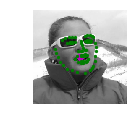

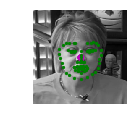

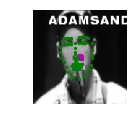

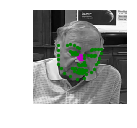

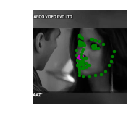

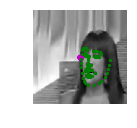

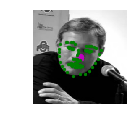

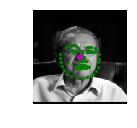

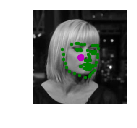

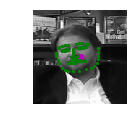

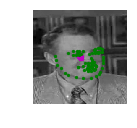

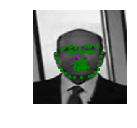

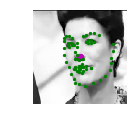

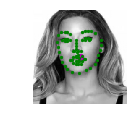

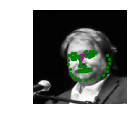

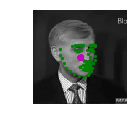

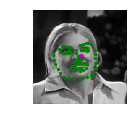

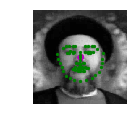

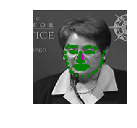

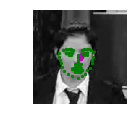

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(5, batch_size/5, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*112+112
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*112+112
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu(), batch_size)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

# criterion = nn.L1Loss()
criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr = 0.02, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr = 0.01)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):    
    # prepare the net for training
    net.train()
    
    # list of epoch loss
    list_epoch_loss = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        epoch_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            # download variables to device
            images = images.to(device)
            key_pts = key_pts.to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            epoch_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                running_loss /= (10*batch_size)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss))
                running_loss = 0.0
                
        # append epoch loss to list
        list_epoch_loss.append(epoch_loss/(batch_size*len(train_loader)))

    print('Finished Training')
    
    return list_epoch_loss


In [15]:
# train your network
n_epochs = 400 # start small, and increase when you've decided on your model structure and hyperparams

# training is faster without weight initialization
# net.apply(weight_init) # init weights
list_epoch_loss = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.005412162318825722
Epoch: 1, Batch: 20, Avg. Loss: 0.003479473777115345
Epoch: 1, Batch: 30, Avg. Loss: 0.0028038339503109453
Epoch: 1, Batch: 40, Avg. Loss: 0.002711458168923855
Epoch: 1, Batch: 50, Avg. Loss: 0.0023953742533922196
Epoch: 1, Batch: 60, Avg. Loss: 0.0023610227555036544
Epoch: 1, Batch: 70, Avg. Loss: 0.002128513380885124
Epoch: 1, Batch: 80, Avg. Loss: 0.0019917650893330574
Epoch: 1, Batch: 90, Avg. Loss: 0.002312746001407504
Epoch: 1, Batch: 100, Avg. Loss: 0.0021100674383342267
Epoch: 1, Batch: 110, Avg. Loss: 0.001940370397642255
Epoch: 1, Batch: 120, Avg. Loss: 0.0019435051176697016
Epoch: 1, Batch: 130, Avg. Loss: 0.0021789891365915537
Epoch: 1, Batch: 140, Avg. Loss: 0.0020957288146018983
Epoch: 1, Batch: 150, Avg. Loss: 0.0024012196250259876
Epoch: 1, Batch: 160, Avg. Loss: 0.0024367610737681387
Epoch: 1, Batch: 170, Avg. Loss: 0.0019991580955684186
Epoch: 2, Batch: 10, Avg. Loss: 0.0017864627856761218
Epoch: 2, Batch: 20, Avg. 

Epoch: 9, Batch: 170, Avg. Loss: 0.0007596729276701808
Epoch: 10, Batch: 10, Avg. Loss: 0.0008226945530623198
Epoch: 10, Batch: 20, Avg. Loss: 0.0007450495334342122
Epoch: 10, Batch: 30, Avg. Loss: 0.001154178217984736
Epoch: 10, Batch: 40, Avg. Loss: 0.0008923405921086669
Epoch: 10, Batch: 50, Avg. Loss: 0.0008936723647639156
Epoch: 10, Batch: 60, Avg. Loss: 0.0007482163840904832
Epoch: 10, Batch: 70, Avg. Loss: 0.0006308169895783066
Epoch: 10, Batch: 80, Avg. Loss: 0.0007569581177085638
Epoch: 10, Batch: 90, Avg. Loss: 0.0009470954397693276
Epoch: 10, Batch: 100, Avg. Loss: 0.000675162635743618
Epoch: 10, Batch: 110, Avg. Loss: 0.0008864877326413989
Epoch: 10, Batch: 120, Avg. Loss: 0.0006976157799363136
Epoch: 10, Batch: 130, Avg. Loss: 0.0008820588840171695
Epoch: 10, Batch: 140, Avg. Loss: 0.0006513694673776627
Epoch: 10, Batch: 150, Avg. Loss: 0.0006604287400841713
Epoch: 10, Batch: 160, Avg. Loss: 0.0006968473503366113
Epoch: 10, Batch: 170, Avg. Loss: 0.0007469532545655965
Epoc

Epoch: 18, Batch: 130, Avg. Loss: 0.0005082666361704469
Epoch: 18, Batch: 140, Avg. Loss: 0.0005726805096492171
Epoch: 18, Batch: 150, Avg. Loss: 0.000539722004905343
Epoch: 18, Batch: 160, Avg. Loss: 0.0005065684649161995
Epoch: 18, Batch: 170, Avg. Loss: 0.00046769665786996486
Epoch: 19, Batch: 10, Avg. Loss: 0.0007349183293990791
Epoch: 19, Batch: 20, Avg. Loss: 0.0005227782181464136
Epoch: 19, Batch: 30, Avg. Loss: 0.0006997137633152306
Epoch: 19, Batch: 40, Avg. Loss: 0.0013499927963130176
Epoch: 19, Batch: 50, Avg. Loss: 0.0006115315621718764
Epoch: 19, Batch: 60, Avg. Loss: 0.0006788928713649512
Epoch: 19, Batch: 70, Avg. Loss: 0.000526935919187963
Epoch: 19, Batch: 80, Avg. Loss: 0.0005122372275218368
Epoch: 19, Batch: 90, Avg. Loss: 0.0006323826336301863
Epoch: 19, Batch: 100, Avg. Loss: 0.0005041165696457029
Epoch: 19, Batch: 110, Avg. Loss: 0.0004859814303927124
Epoch: 19, Batch: 120, Avg. Loss: 0.00043453937396407125
Epoch: 19, Batch: 130, Avg. Loss: 0.0006299853045493364
E

Epoch: 27, Batch: 80, Avg. Loss: 0.0005138791352510452
Epoch: 27, Batch: 90, Avg. Loss: 0.00041321167722344396
Epoch: 27, Batch: 100, Avg. Loss: 0.0005357888038270176
Epoch: 27, Batch: 110, Avg. Loss: 0.0003762362035922706
Epoch: 27, Batch: 120, Avg. Loss: 0.0004391889227554202
Epoch: 27, Batch: 130, Avg. Loss: 0.000514018926769495
Epoch: 27, Batch: 140, Avg. Loss: 0.0004016091488301754
Epoch: 27, Batch: 150, Avg. Loss: 0.00044703272404149173
Epoch: 27, Batch: 160, Avg. Loss: 0.00040447188075631857
Epoch: 27, Batch: 170, Avg. Loss: 0.00038910203613340855
Epoch: 28, Batch: 10, Avg. Loss: 0.000529392200987786
Epoch: 28, Batch: 20, Avg. Loss: 0.000495845447294414
Epoch: 28, Batch: 30, Avg. Loss: 0.00039250971283763644
Epoch: 28, Batch: 40, Avg. Loss: 0.0005052975658327341
Epoch: 28, Batch: 50, Avg. Loss: 0.0006990253110416234
Epoch: 28, Batch: 60, Avg. Loss: 0.0004453205084428191
Epoch: 28, Batch: 70, Avg. Loss: 0.0005291048623621464
Epoch: 28, Batch: 80, Avg. Loss: 0.00047480741050094367

Epoch: 36, Batch: 20, Avg. Loss: 0.00034042737213894723
Epoch: 36, Batch: 30, Avg. Loss: 0.0004944017203524709
Epoch: 36, Batch: 40, Avg. Loss: 0.0003620459302328527
Epoch: 36, Batch: 50, Avg. Loss: 0.0005043841130100191
Epoch: 36, Batch: 60, Avg. Loss: 0.0003748218133114278
Epoch: 36, Batch: 70, Avg. Loss: 0.0003482386819086969
Epoch: 36, Batch: 80, Avg. Loss: 0.00037610181607306004
Epoch: 36, Batch: 90, Avg. Loss: 0.000384198809042573
Epoch: 36, Batch: 100, Avg. Loss: 0.0003733086003921926
Epoch: 36, Batch: 110, Avg. Loss: 0.000708482563495636
Epoch: 36, Batch: 120, Avg. Loss: 0.0005635659419931471
Epoch: 36, Batch: 130, Avg. Loss: 0.0003738458384759724
Epoch: 36, Batch: 140, Avg. Loss: 0.0005336756445467472
Epoch: 36, Batch: 150, Avg. Loss: 0.0003623343491926789
Epoch: 36, Batch: 160, Avg. Loss: 0.0003374143270775676
Epoch: 36, Batch: 170, Avg. Loss: 0.00040173541754484176
Epoch: 37, Batch: 10, Avg. Loss: 0.0003534165793098509
Epoch: 37, Batch: 20, Avg. Loss: 0.0003175555565394461
E

Epoch: 44, Batch: 130, Avg. Loss: 0.00035616497974842785
Epoch: 44, Batch: 140, Avg. Loss: 0.00036671075969934463
Epoch: 44, Batch: 150, Avg. Loss: 0.0007678264728747308
Epoch: 44, Batch: 160, Avg. Loss: 0.0005137443565763533
Epoch: 44, Batch: 170, Avg. Loss: 0.0003547782055102289
Epoch: 45, Batch: 10, Avg. Loss: 0.00033315479289740323
Epoch: 45, Batch: 20, Avg. Loss: 0.0007008352829143405
Epoch: 45, Batch: 30, Avg. Loss: 0.00038775396998971703
Epoch: 45, Batch: 40, Avg. Loss: 0.00034151390194892884
Epoch: 45, Batch: 50, Avg. Loss: 0.00032401705859228967
Epoch: 45, Batch: 60, Avg. Loss: 0.00033021477283909915
Epoch: 45, Batch: 70, Avg. Loss: 0.0002938559534959495
Epoch: 45, Batch: 80, Avg. Loss: 0.00032534606056287883
Epoch: 45, Batch: 90, Avg. Loss: 0.0003015864547342062
Epoch: 45, Batch: 100, Avg. Loss: 0.0002992141991853714
Epoch: 45, Batch: 110, Avg. Loss: 0.00034395990194752813
Epoch: 45, Batch: 120, Avg. Loss: 0.0003428209270350635
Epoch: 45, Batch: 130, Avg. Loss: 0.000420777155

Epoch: 53, Batch: 70, Avg. Loss: 0.00031519855721853676
Epoch: 53, Batch: 80, Avg. Loss: 0.00028795157093554737
Epoch: 53, Batch: 90, Avg. Loss: 0.00030841293511912226
Epoch: 53, Batch: 100, Avg. Loss: 0.00030853413278236985
Epoch: 53, Batch: 110, Avg. Loss: 0.0002642878470942378
Epoch: 53, Batch: 120, Avg. Loss: 0.00023514416068792343
Epoch: 53, Batch: 130, Avg. Loss: 0.0003044548130128533
Epoch: 53, Batch: 140, Avg. Loss: 0.0003084969869814813
Epoch: 53, Batch: 150, Avg. Loss: 0.000303904430475086
Epoch: 53, Batch: 160, Avg. Loss: 0.0003222360310610384
Epoch: 53, Batch: 170, Avg. Loss: 0.00032025273772887884
Epoch: 54, Batch: 10, Avg. Loss: 0.00030471752514131366
Epoch: 54, Batch: 20, Avg. Loss: 0.000313244191929698
Epoch: 54, Batch: 30, Avg. Loss: 0.0003213418903760612
Epoch: 54, Batch: 40, Avg. Loss: 0.00028299995698034765
Epoch: 54, Batch: 50, Avg. Loss: 0.0007293045334517956
Epoch: 54, Batch: 60, Avg. Loss: 0.0003320829197764397
Epoch: 54, Batch: 70, Avg. Loss: 0.0003256033523939

Epoch: 62, Batch: 10, Avg. Loss: 0.0002817815891467035
Epoch: 62, Batch: 20, Avg. Loss: 0.0002898495411500335
Epoch: 62, Batch: 30, Avg. Loss: 0.00027899689972400667
Epoch: 62, Batch: 40, Avg. Loss: 0.00032623163424432277
Epoch: 62, Batch: 50, Avg. Loss: 0.0003001829492859542
Epoch: 62, Batch: 60, Avg. Loss: 0.0002524616348091513
Epoch: 62, Batch: 70, Avg. Loss: 0.0002782385074533522
Epoch: 62, Batch: 80, Avg. Loss: 0.0003016951098106801
Epoch: 62, Batch: 90, Avg. Loss: 0.00027705778600648043
Epoch: 62, Batch: 100, Avg. Loss: 0.0003022516134660691
Epoch: 62, Batch: 110, Avg. Loss: 0.0006524364044889808
Epoch: 62, Batch: 120, Avg. Loss: 0.00033796015661209823
Epoch: 62, Batch: 130, Avg. Loss: 0.00034185352036729454
Epoch: 62, Batch: 140, Avg. Loss: 0.00027028906624764203
Epoch: 62, Batch: 150, Avg. Loss: 0.00031301278620958327
Epoch: 62, Batch: 160, Avg. Loss: 0.00026584526873193684
Epoch: 62, Batch: 170, Avg. Loss: 0.00025817178888246415
Epoch: 63, Batch: 10, Avg. Loss: 0.0002998889819

Epoch: 70, Batch: 120, Avg. Loss: 0.00023900580126792192
Epoch: 70, Batch: 130, Avg. Loss: 0.00024529664195142685
Epoch: 70, Batch: 140, Avg. Loss: 0.00026201845379546283
Epoch: 70, Batch: 150, Avg. Loss: 0.0002859918400645256
Epoch: 70, Batch: 160, Avg. Loss: 0.0003909578209277242
Epoch: 70, Batch: 170, Avg. Loss: 0.00032125403988175093
Epoch: 71, Batch: 10, Avg. Loss: 0.0002584426512476057
Epoch: 71, Batch: 20, Avg. Loss: 0.0002673292811959982
Epoch: 71, Batch: 30, Avg. Loss: 0.0002636839915066958
Epoch: 71, Batch: 40, Avg. Loss: 0.00029006247175857426
Epoch: 71, Batch: 50, Avg. Loss: 0.0002500988950487226
Epoch: 71, Batch: 60, Avg. Loss: 0.00023238933994434774
Epoch: 71, Batch: 70, Avg. Loss: 0.0003984248696360737
Epoch: 71, Batch: 80, Avg. Loss: 0.0002517562091816217
Epoch: 71, Batch: 90, Avg. Loss: 0.00027519236085936426
Epoch: 71, Batch: 100, Avg. Loss: 0.0002733250590972602
Epoch: 71, Batch: 110, Avg. Loss: 0.0005503494245931506
Epoch: 71, Batch: 120, Avg. Loss: 0.00030130686005

Epoch: 79, Batch: 60, Avg. Loss: 0.000272017716197297
Epoch: 79, Batch: 70, Avg. Loss: 0.00028196515631861985
Epoch: 79, Batch: 80, Avg. Loss: 0.00022417983738705515
Epoch: 79, Batch: 90, Avg. Loss: 0.00025648541981354356
Epoch: 79, Batch: 100, Avg. Loss: 0.00024253050331026315
Epoch: 79, Batch: 110, Avg. Loss: 0.00023654570104554297
Epoch: 79, Batch: 120, Avg. Loss: 0.0005661974311806262
Epoch: 79, Batch: 130, Avg. Loss: 0.0002717031515203416
Epoch: 79, Batch: 140, Avg. Loss: 0.00041373673710040746
Epoch: 79, Batch: 150, Avg. Loss: 0.00025536282453686
Epoch: 79, Batch: 160, Avg. Loss: 0.00023342555854469538
Epoch: 79, Batch: 170, Avg. Loss: 0.0002496516203973442
Epoch: 80, Batch: 10, Avg. Loss: 0.0002630449901334941
Epoch: 80, Batch: 20, Avg. Loss: 0.00027974031399935484
Epoch: 80, Batch: 30, Avg. Loss: 0.0002477167989127338
Epoch: 80, Batch: 40, Avg. Loss: 0.0007628470368217677
Epoch: 80, Batch: 50, Avg. Loss: 0.00028903620084747673
Epoch: 80, Batch: 60, Avg. Loss: 0.0003623269917443

Epoch: 87, Batch: 170, Avg. Loss: 0.0002863020286895335
Epoch: 88, Batch: 10, Avg. Loss: 0.00020695838262327015
Epoch: 88, Batch: 20, Avg. Loss: 0.00026620650081895294
Epoch: 88, Batch: 30, Avg. Loss: 0.00021374668111093342
Epoch: 88, Batch: 40, Avg. Loss: 0.0002651783381588757
Epoch: 88, Batch: 50, Avg. Loss: 0.0005648951872717589
Epoch: 88, Batch: 60, Avg. Loss: 0.00027536571491509676
Epoch: 88, Batch: 70, Avg. Loss: 0.0002344677469227463
Epoch: 88, Batch: 80, Avg. Loss: 0.00024199407896958292
Epoch: 88, Batch: 90, Avg. Loss: 0.0002988008817192167
Epoch: 88, Batch: 100, Avg. Loss: 0.00023497887537814676
Epoch: 88, Batch: 110, Avg. Loss: 0.00023447376559488476
Epoch: 88, Batch: 120, Avg. Loss: 0.00023408949258737265
Epoch: 88, Batch: 130, Avg. Loss: 0.00026007440756075083
Epoch: 88, Batch: 140, Avg. Loss: 0.000387624055147171
Epoch: 88, Batch: 150, Avg. Loss: 0.00027001131791621447
Epoch: 88, Batch: 160, Avg. Loss: 0.00025719853350892664
Epoch: 88, Batch: 170, Avg. Loss: 0.00026329127

Epoch: 96, Batch: 110, Avg. Loss: 0.00018472518655471504
Epoch: 96, Batch: 120, Avg. Loss: 0.00028822479187510906
Epoch: 96, Batch: 130, Avg. Loss: 0.00022824704297818243
Epoch: 96, Batch: 140, Avg. Loss: 0.00022927279700525106
Epoch: 96, Batch: 150, Avg. Loss: 0.00022542040795087815
Epoch: 96, Batch: 160, Avg. Loss: 0.0002147490531206131
Epoch: 96, Batch: 170, Avg. Loss: 0.00022577269468456506
Epoch: 97, Batch: 10, Avg. Loss: 0.00022060977411456406
Epoch: 97, Batch: 20, Avg. Loss: 0.00021375591051764787
Epoch: 97, Batch: 30, Avg. Loss: 0.00023275907966308296
Epoch: 97, Batch: 40, Avg. Loss: 0.00022329104831442237
Epoch: 97, Batch: 50, Avg. Loss: 0.00019909392925910653
Epoch: 97, Batch: 60, Avg. Loss: 0.00023251190781593324
Epoch: 97, Batch: 70, Avg. Loss: 0.00023456304450519383
Epoch: 97, Batch: 80, Avg. Loss: 0.00020836941432207822
Epoch: 97, Batch: 90, Avg. Loss: 0.000271022729575634
Epoch: 97, Batch: 100, Avg. Loss: 0.00020174936624243857
Epoch: 97, Batch: 110, Avg. Loss: 0.0002051

Epoch: 105, Batch: 30, Avg. Loss: 0.00029781255521811546
Epoch: 105, Batch: 40, Avg. Loss: 0.0003350675094407052
Epoch: 105, Batch: 50, Avg. Loss: 0.00023858993779867887
Epoch: 105, Batch: 60, Avg. Loss: 0.00022700764355249704
Epoch: 105, Batch: 70, Avg. Loss: 0.00023207053425721824
Epoch: 105, Batch: 80, Avg. Loss: 0.00021472429158166052
Epoch: 105, Batch: 90, Avg. Loss: 0.00022028668434359133
Epoch: 105, Batch: 100, Avg. Loss: 0.0002074816299136728
Epoch: 105, Batch: 110, Avg. Loss: 0.00023276985506527127
Epoch: 105, Batch: 120, Avg. Loss: 0.00023135181982070208
Epoch: 105, Batch: 130, Avg. Loss: 0.00021196234738454222
Epoch: 105, Batch: 140, Avg. Loss: 0.0002101054252125323
Epoch: 105, Batch: 150, Avg. Loss: 0.00021562682930380107
Epoch: 105, Batch: 160, Avg. Loss: 0.00023007823270745575
Epoch: 105, Batch: 170, Avg. Loss: 0.00019584374618716538
Epoch: 106, Batch: 10, Avg. Loss: 0.000257326535647735
Epoch: 106, Batch: 20, Avg. Loss: 0.00022716946899890898
Epoch: 106, Batch: 30, Avg. 

Epoch: 113, Batch: 110, Avg. Loss: 0.0003569678962230682
Epoch: 113, Batch: 120, Avg. Loss: 0.00025212278706021607
Epoch: 113, Batch: 130, Avg. Loss: 0.0002045545307919383
Epoch: 113, Batch: 140, Avg. Loss: 0.00025683559477329254
Epoch: 113, Batch: 150, Avg. Loss: 0.000220773764885962
Epoch: 113, Batch: 160, Avg. Loss: 0.00022396307438611983
Epoch: 113, Batch: 170, Avg. Loss: 0.00025207965169101956
Epoch: 114, Batch: 10, Avg. Loss: 0.0002531968534458429
Epoch: 114, Batch: 20, Avg. Loss: 0.0002288147050421685
Epoch: 114, Batch: 30, Avg. Loss: 0.00018728838418610394
Epoch: 114, Batch: 40, Avg. Loss: 0.00020005473168566824
Epoch: 114, Batch: 50, Avg. Loss: 0.0003944811294786632
Epoch: 114, Batch: 60, Avg. Loss: 0.00019881267566233872
Epoch: 114, Batch: 70, Avg. Loss: 0.00038294634665362535
Epoch: 114, Batch: 80, Avg. Loss: 0.0001843717007432133
Epoch: 114, Batch: 90, Avg. Loss: 0.0003390069724991918
Epoch: 114, Batch: 100, Avg. Loss: 0.00023472422850318253
Epoch: 114, Batch: 110, Avg. Los

Epoch: 122, Batch: 20, Avg. Loss: 0.00018523480277508498
Epoch: 122, Batch: 30, Avg. Loss: 0.00020794088137336076
Epoch: 122, Batch: 40, Avg. Loss: 0.00020516376942396165
Epoch: 122, Batch: 50, Avg. Loss: 0.00020372116472572088
Epoch: 122, Batch: 60, Avg. Loss: 0.00029459242941811683
Epoch: 122, Batch: 70, Avg. Loss: 0.0002380011708009988
Epoch: 122, Batch: 80, Avg. Loss: 0.00016150948475115
Epoch: 122, Batch: 90, Avg. Loss: 0.0001888836733996868
Epoch: 122, Batch: 100, Avg. Loss: 0.0002889875415712595
Epoch: 122, Batch: 110, Avg. Loss: 0.00022743654204532504
Epoch: 122, Batch: 120, Avg. Loss: 0.00020464174216613173
Epoch: 122, Batch: 130, Avg. Loss: 0.00021164826350286603
Epoch: 122, Batch: 140, Avg. Loss: 0.000197044110391289
Epoch: 122, Batch: 150, Avg. Loss: 0.00018620159244164824
Epoch: 122, Batch: 160, Avg. Loss: 0.00023043169174343347
Epoch: 122, Batch: 170, Avg. Loss: 0.00019392110407352449
Epoch: 123, Batch: 10, Avg. Loss: 0.00019333165138959885
Epoch: 123, Batch: 20, Avg. Los

Epoch: 130, Batch: 100, Avg. Loss: 0.0002533175132703036
Epoch: 130, Batch: 110, Avg. Loss: 0.00028769804048351945
Epoch: 130, Batch: 120, Avg. Loss: 0.0001921483874320984
Epoch: 130, Batch: 130, Avg. Loss: 0.00019964392646215856
Epoch: 130, Batch: 140, Avg. Loss: 0.0001689578965306282
Epoch: 130, Batch: 150, Avg. Loss: 0.00017035342985764147
Epoch: 130, Batch: 160, Avg. Loss: 0.0002121168444864452
Epoch: 130, Batch: 170, Avg. Loss: 0.00016657459666021167
Epoch: 131, Batch: 10, Avg. Loss: 0.00021846915944479406
Epoch: 131, Batch: 20, Avg. Loss: 0.00020268615568056703
Epoch: 131, Batch: 30, Avg. Loss: 0.00019676090683788062
Epoch: 131, Batch: 40, Avg. Loss: 0.00025543274008668957
Epoch: 131, Batch: 50, Avg. Loss: 0.00017813704209402204
Epoch: 131, Batch: 60, Avg. Loss: 0.00019069455098360777
Epoch: 131, Batch: 70, Avg. Loss: 0.0002507275529205799
Epoch: 131, Batch: 80, Avg. Loss: 0.00019787880475632846
Epoch: 131, Batch: 90, Avg. Loss: 0.00022177984938025473
Epoch: 131, Batch: 100, Avg.

Epoch: 139, Batch: 10, Avg. Loss: 0.0001925501402001828
Epoch: 139, Batch: 20, Avg. Loss: 0.00018584495526738465
Epoch: 139, Batch: 30, Avg. Loss: 0.0001737483940087259
Epoch: 139, Batch: 40, Avg. Loss: 0.00048343533999286594
Epoch: 139, Batch: 50, Avg. Loss: 0.0002242035826202482
Epoch: 139, Batch: 60, Avg. Loss: 0.0002563364966772497
Epoch: 139, Batch: 70, Avg. Loss: 0.00021935279481112956
Epoch: 139, Batch: 80, Avg. Loss: 0.0002036652050446719
Epoch: 139, Batch: 90, Avg. Loss: 0.0002435203013010323
Epoch: 139, Batch: 100, Avg. Loss: 0.00019745140918530523
Epoch: 139, Batch: 110, Avg. Loss: 0.00020703780464828014
Epoch: 139, Batch: 120, Avg. Loss: 0.00016962646041065454
Epoch: 139, Batch: 130, Avg. Loss: 0.00022999977692961693
Epoch: 139, Batch: 140, Avg. Loss: 0.00017542000277899207
Epoch: 139, Batch: 150, Avg. Loss: 0.0001938376179896295
Epoch: 139, Batch: 160, Avg. Loss: 0.0002730925497598946
Epoch: 139, Batch: 170, Avg. Loss: 0.0001857477822341025
Epoch: 140, Batch: 10, Avg. Loss

Epoch: 147, Batch: 90, Avg. Loss: 0.0002618397551123053
Epoch: 147, Batch: 100, Avg. Loss: 0.0002022984146606177
Epoch: 147, Batch: 110, Avg. Loss: 0.00020417282707057893
Epoch: 147, Batch: 120, Avg. Loss: 0.00017066215979866684
Epoch: 147, Batch: 130, Avg. Loss: 0.00018320598290301858
Epoch: 147, Batch: 140, Avg. Loss: 0.0001895879628136754
Epoch: 147, Batch: 150, Avg. Loss: 0.0002075924095697701
Epoch: 147, Batch: 160, Avg. Loss: 0.00016882687574252487
Epoch: 147, Batch: 170, Avg. Loss: 0.00015248103067278863
Epoch: 148, Batch: 10, Avg. Loss: 0.00036727898404933514
Epoch: 148, Batch: 20, Avg. Loss: 0.0001674880343489349
Epoch: 148, Batch: 30, Avg. Loss: 0.0001865534798707813
Epoch: 148, Batch: 40, Avg. Loss: 0.0002201226889155805
Epoch: 148, Batch: 50, Avg. Loss: 0.00020028799073770642
Epoch: 148, Batch: 60, Avg. Loss: 0.00017893510404974223
Epoch: 148, Batch: 70, Avg. Loss: 0.00019411986344493925
Epoch: 148, Batch: 80, Avg. Loss: 0.0002155371627304703
Epoch: 148, Batch: 90, Avg. Los

Epoch: 155, Batch: 170, Avg. Loss: 0.0001640731596853584
Epoch: 156, Batch: 10, Avg. Loss: 0.00015059389756061137
Epoch: 156, Batch: 20, Avg. Loss: 0.00018624689313583075
Epoch: 156, Batch: 30, Avg. Loss: 0.00018223330960609018
Epoch: 156, Batch: 40, Avg. Loss: 0.00019050620496273042
Epoch: 156, Batch: 50, Avg. Loss: 0.00018477278179489077
Epoch: 156, Batch: 60, Avg. Loss: 0.0001662815094459802
Epoch: 156, Batch: 70, Avg. Loss: 0.00017285781679674984
Epoch: 156, Batch: 80, Avg. Loss: 0.00015868139802478255
Epoch: 156, Batch: 90, Avg. Loss: 0.00015613327850587665
Epoch: 156, Batch: 100, Avg. Loss: 0.00016551472712308168
Epoch: 156, Batch: 110, Avg. Loss: 0.0001663649477995932
Epoch: 156, Batch: 120, Avg. Loss: 0.0002258644171524793
Epoch: 156, Batch: 130, Avg. Loss: 0.00017630107467994093
Epoch: 156, Batch: 140, Avg. Loss: 0.00018757824553176762
Epoch: 156, Batch: 150, Avg. Loss: 0.00017266195034608246
Epoch: 156, Batch: 160, Avg. Loss: 0.00018058197339996696
Epoch: 156, Batch: 170, Avg

Epoch: 164, Batch: 80, Avg. Loss: 0.00016694570891559124
Epoch: 164, Batch: 90, Avg. Loss: 0.00018993695848621429
Epoch: 164, Batch: 100, Avg. Loss: 0.00016689644195139408
Epoch: 164, Batch: 110, Avg. Loss: 0.00016037068096920847
Epoch: 164, Batch: 120, Avg. Loss: 0.00015226420597173274
Epoch: 164, Batch: 130, Avg. Loss: 0.00018763637519441544
Epoch: 164, Batch: 140, Avg. Loss: 0.00018665608600713313
Epoch: 164, Batch: 150, Avg. Loss: 0.00018697348423302174
Epoch: 164, Batch: 160, Avg. Loss: 0.00018445544759742915
Epoch: 164, Batch: 170, Avg. Loss: 0.00022287760977633298
Epoch: 165, Batch: 10, Avg. Loss: 0.00024381930707022547
Epoch: 165, Batch: 20, Avg. Loss: 0.00016077236738055946
Epoch: 165, Batch: 30, Avg. Loss: 0.00015692331886384635
Epoch: 165, Batch: 40, Avg. Loss: 0.000151048720581457
Epoch: 165, Batch: 50, Avg. Loss: 0.00024051698273979126
Epoch: 165, Batch: 60, Avg. Loss: 0.00022043235134333372
Epoch: 165, Batch: 70, Avg. Loss: 0.00018675505183637141
Epoch: 165, Batch: 80, Av

Epoch: 172, Batch: 160, Avg. Loss: 0.0001546008069999516
Epoch: 172, Batch: 170, Avg. Loss: 0.00022599263465963304
Epoch: 173, Batch: 10, Avg. Loss: 0.00018652443308383226
Epoch: 173, Batch: 20, Avg. Loss: 0.00020190133363939822
Epoch: 173, Batch: 30, Avg. Loss: 0.00016692994046024978
Epoch: 173, Batch: 40, Avg. Loss: 0.00023489339859224855
Epoch: 173, Batch: 50, Avg. Loss: 0.00018805338884703816
Epoch: 173, Batch: 60, Avg. Loss: 0.00015735911787487567
Epoch: 173, Batch: 70, Avg. Loss: 0.00022250050271395593
Epoch: 173, Batch: 80, Avg. Loss: 0.00016728539019823075
Epoch: 173, Batch: 90, Avg. Loss: 0.0001833359175361693
Epoch: 173, Batch: 100, Avg. Loss: 0.00017283721943385898
Epoch: 173, Batch: 110, Avg. Loss: 0.00017310117254965007
Epoch: 173, Batch: 120, Avg. Loss: 0.0001380837522447109
Epoch: 173, Batch: 130, Avg. Loss: 0.00018073868472129106
Epoch: 173, Batch: 140, Avg. Loss: 0.00015859671868383884
Epoch: 173, Batch: 150, Avg. Loss: 0.0001798353681806475
Epoch: 173, Batch: 160, Avg

Epoch: 181, Batch: 70, Avg. Loss: 0.0002469397243112326
Epoch: 181, Batch: 80, Avg. Loss: 0.00016763522871769964
Epoch: 181, Batch: 90, Avg. Loss: 0.00014946109266020358
Epoch: 181, Batch: 100, Avg. Loss: 0.00016167926136404276
Epoch: 181, Batch: 110, Avg. Loss: 0.0001515137415844947
Epoch: 181, Batch: 120, Avg. Loss: 0.00014403513167053462
Epoch: 181, Batch: 130, Avg. Loss: 0.00015397982089780272
Epoch: 181, Batch: 140, Avg. Loss: 0.00024576033116318285
Epoch: 181, Batch: 150, Avg. Loss: 0.0001525521615985781
Epoch: 181, Batch: 160, Avg. Loss: 0.00020838445285335184
Epoch: 181, Batch: 170, Avg. Loss: 0.00017737417947500945
Epoch: 182, Batch: 10, Avg. Loss: 0.0003136454394552857
Epoch: 182, Batch: 20, Avg. Loss: 0.00017472794861532747
Epoch: 182, Batch: 30, Avg. Loss: 0.0002317922213114798
Epoch: 182, Batch: 40, Avg. Loss: 0.0001587282551918179
Epoch: 182, Batch: 50, Avg. Loss: 0.00020634290878660978
Epoch: 182, Batch: 60, Avg. Loss: 0.00017242145957425237
Epoch: 182, Batch: 70, Avg. L

Epoch: 189, Batch: 150, Avg. Loss: 0.00016726435860618948
Epoch: 189, Batch: 160, Avg. Loss: 0.00015521690249443055
Epoch: 189, Batch: 170, Avg. Loss: 0.0001452847005566582
Epoch: 190, Batch: 10, Avg. Loss: 0.0002658531960332766
Epoch: 190, Batch: 20, Avg. Loss: 0.0001605018659029156
Epoch: 190, Batch: 30, Avg. Loss: 0.0001700554322451353
Epoch: 190, Batch: 40, Avg. Loss: 0.00017442448413930832
Epoch: 190, Batch: 50, Avg. Loss: 0.00017360662459395826
Epoch: 190, Batch: 60, Avg. Loss: 0.00017592388903722166
Epoch: 190, Batch: 70, Avg. Loss: 0.00021150999469682574
Epoch: 190, Batch: 80, Avg. Loss: 0.0001672948175109923
Epoch: 190, Batch: 90, Avg. Loss: 0.000368236965732649
Epoch: 190, Batch: 100, Avg. Loss: 0.00019355522701516747
Epoch: 190, Batch: 110, Avg. Loss: 0.00015771672362461687
Epoch: 190, Batch: 120, Avg. Loss: 0.00015249204356223344
Epoch: 190, Batch: 130, Avg. Loss: 0.00016785696032457054
Epoch: 190, Batch: 140, Avg. Loss: 0.00021291857585310935
Epoch: 190, Batch: 150, Avg. L

Epoch: 198, Batch: 60, Avg. Loss: 0.00016458543133921922
Epoch: 198, Batch: 70, Avg. Loss: 0.00015976598835550247
Epoch: 198, Batch: 80, Avg. Loss: 0.00014628108590841293
Epoch: 198, Batch: 90, Avg. Loss: 0.00014512469875626265
Epoch: 198, Batch: 100, Avg. Loss: 0.00014304827491287141
Epoch: 198, Batch: 110, Avg. Loss: 0.0001486009079962969
Epoch: 198, Batch: 120, Avg. Loss: 0.00014610292913857847
Epoch: 198, Batch: 130, Avg. Loss: 0.0001586977986153215
Epoch: 198, Batch: 140, Avg. Loss: 0.00016645437572151422
Epoch: 198, Batch: 150, Avg. Loss: 0.00016716456389985978
Epoch: 198, Batch: 160, Avg. Loss: 0.0001710013404954225
Epoch: 198, Batch: 170, Avg. Loss: 0.0001362355495803058
Epoch: 199, Batch: 10, Avg. Loss: 0.0001780711568426341
Epoch: 199, Batch: 20, Avg. Loss: 0.00018482960644178092
Epoch: 199, Batch: 30, Avg. Loss: 0.00016695825033821165
Epoch: 199, Batch: 40, Avg. Loss: 0.00015611742623150348
Epoch: 199, Batch: 50, Avg. Loss: 0.00018805497675202786
Epoch: 199, Batch: 60, Avg. 

Epoch: 206, Batch: 140, Avg. Loss: 0.00029348728712648154
Epoch: 206, Batch: 150, Avg. Loss: 0.00017307364498265088
Epoch: 206, Batch: 160, Avg. Loss: 0.00016174046322703362
Epoch: 206, Batch: 170, Avg. Loss: 0.00016315494081936777
Epoch: 207, Batch: 10, Avg. Loss: 0.0001636058243457228
Epoch: 207, Batch: 20, Avg. Loss: 0.0002124425966758281
Epoch: 207, Batch: 30, Avg. Loss: 0.0001749290735460818
Epoch: 207, Batch: 40, Avg. Loss: 0.00014614457380957902
Epoch: 207, Batch: 50, Avg. Loss: 0.00017034602118656038
Epoch: 207, Batch: 60, Avg. Loss: 0.00017598996055312455
Epoch: 207, Batch: 70, Avg. Loss: 0.00017184821073897182
Epoch: 207, Batch: 80, Avg. Loss: 0.0001714126893784851
Epoch: 207, Batch: 90, Avg. Loss: 0.0001433585351333022
Epoch: 207, Batch: 100, Avg. Loss: 0.00014376178092788904
Epoch: 207, Batch: 110, Avg. Loss: 0.00014490167493931948
Epoch: 207, Batch: 120, Avg. Loss: 0.0001510700141079724
Epoch: 207, Batch: 130, Avg. Loss: 0.00013621942256577312
Epoch: 207, Batch: 140, Avg. 

Epoch: 215, Batch: 50, Avg. Loss: 0.00019544073846191167
Epoch: 215, Batch: 60, Avg. Loss: 0.00014851258136332036
Epoch: 215, Batch: 70, Avg. Loss: 0.00016863386845216154
Epoch: 215, Batch: 80, Avg. Loss: 0.00014965015463531018
Epoch: 215, Batch: 90, Avg. Loss: 0.00017895332421176137
Epoch: 215, Batch: 100, Avg. Loss: 0.00016962874040473252
Epoch: 215, Batch: 110, Avg. Loss: 0.00019075110205449164
Epoch: 215, Batch: 120, Avg. Loss: 0.00016222550650127232
Epoch: 215, Batch: 130, Avg. Loss: 0.00016014616005122662
Epoch: 215, Batch: 140, Avg. Loss: 0.00017872056108899414
Epoch: 215, Batch: 150, Avg. Loss: 0.00012817894923500717
Epoch: 215, Batch: 160, Avg. Loss: 0.0001882757304701954
Epoch: 215, Batch: 170, Avg. Loss: 0.000132970935665071
Epoch: 216, Batch: 10, Avg. Loss: 0.00014945169852580875
Epoch: 216, Batch: 20, Avg. Loss: 0.00015418648428749292
Epoch: 216, Batch: 30, Avg. Loss: 0.0001608672901056707
Epoch: 216, Batch: 40, Avg. Loss: 0.00015687941573560237
Epoch: 216, Batch: 50, Avg.

Epoch: 223, Batch: 130, Avg. Loss: 0.00016895829699933529
Epoch: 223, Batch: 140, Avg. Loss: 0.00016740784631110727
Epoch: 223, Batch: 150, Avg. Loss: 0.00017215943429619074
Epoch: 223, Batch: 160, Avg. Loss: 0.00013776929350569844
Epoch: 223, Batch: 170, Avg. Loss: 0.00015504227252677083
Epoch: 224, Batch: 10, Avg. Loss: 0.00014438627113122493
Epoch: 224, Batch: 20, Avg. Loss: 0.00016085526905953884
Epoch: 224, Batch: 30, Avg. Loss: 0.00016594167449511586
Epoch: 224, Batch: 40, Avg. Loss: 0.0001369037589756772
Epoch: 224, Batch: 50, Avg. Loss: 0.00015187136130407453
Epoch: 224, Batch: 60, Avg. Loss: 0.00015321334125474096
Epoch: 224, Batch: 70, Avg. Loss: 0.000159672349691391
Epoch: 224, Batch: 80, Avg. Loss: 0.00014125656918622553
Epoch: 224, Batch: 90, Avg. Loss: 0.00018795353593304754
Epoch: 224, Batch: 100, Avg. Loss: 0.00014944878639653326
Epoch: 224, Batch: 110, Avg. Loss: 0.00014665930822957307
Epoch: 224, Batch: 120, Avg. Loss: 0.00017914086813107134
Epoch: 224, Batch: 130, Av

Epoch: 232, Batch: 40, Avg. Loss: 0.00017933669267222285
Epoch: 232, Batch: 50, Avg. Loss: 0.00015530844451859592
Epoch: 232, Batch: 60, Avg. Loss: 0.00014319173409603535
Epoch: 232, Batch: 70, Avg. Loss: 0.00014349656645208598
Epoch: 232, Batch: 80, Avg. Loss: 0.00013495523598976432
Epoch: 232, Batch: 90, Avg. Loss: 0.0001510349998716265
Epoch: 232, Batch: 100, Avg. Loss: 0.00015318965073674918
Epoch: 232, Batch: 110, Avg. Loss: 0.0001636605558451265
Epoch: 232, Batch: 120, Avg. Loss: 0.00012665652437135577
Epoch: 232, Batch: 130, Avg. Loss: 0.00013237980543635787
Epoch: 232, Batch: 140, Avg. Loss: 0.00014084307651501148
Epoch: 232, Batch: 150, Avg. Loss: 0.00015272242948412894
Epoch: 232, Batch: 160, Avg. Loss: 0.0001543672929983586
Epoch: 232, Batch: 170, Avg. Loss: 0.00015297067468054594
Epoch: 233, Batch: 10, Avg. Loss: 0.00016691738157533108
Epoch: 233, Batch: 20, Avg. Loss: 0.00015784877236001192
Epoch: 233, Batch: 30, Avg. Loss: 0.00015725395875051617
Epoch: 233, Batch: 40, Avg

Epoch: 240, Batch: 120, Avg. Loss: 0.00013685005251318216
Epoch: 240, Batch: 130, Avg. Loss: 0.00016804673010483383
Epoch: 240, Batch: 140, Avg. Loss: 0.0001374608837068081
Epoch: 240, Batch: 150, Avg. Loss: 0.0001398322032764554
Epoch: 240, Batch: 160, Avg. Loss: 0.00016445327433757485
Epoch: 240, Batch: 170, Avg. Loss: 0.0001631274144165218
Epoch: 241, Batch: 10, Avg. Loss: 0.00015164156560786067
Epoch: 241, Batch: 20, Avg. Loss: 0.00015731624327600002
Epoch: 241, Batch: 30, Avg. Loss: 0.0001381785119883716
Epoch: 241, Batch: 40, Avg. Loss: 0.00014645190036389978
Epoch: 241, Batch: 50, Avg. Loss: 0.00014353470993228257
Epoch: 241, Batch: 60, Avg. Loss: 0.00015956355608068407
Epoch: 241, Batch: 70, Avg. Loss: 0.00014083496527746319
Epoch: 241, Batch: 80, Avg. Loss: 0.00016552005894482136
Epoch: 241, Batch: 90, Avg. Loss: 0.0001461388246389106
Epoch: 241, Batch: 100, Avg. Loss: 0.0001446716656209901
Epoch: 241, Batch: 110, Avg. Loss: 0.00013585134758614003
Epoch: 241, Batch: 120, Avg. 

Epoch: 249, Batch: 30, Avg. Loss: 0.00013591887138318271
Epoch: 249, Batch: 40, Avg. Loss: 0.00015486382064409555
Epoch: 249, Batch: 50, Avg. Loss: 0.00012651091325096786
Epoch: 249, Batch: 60, Avg. Loss: 0.0001512787479441613
Epoch: 249, Batch: 70, Avg. Loss: 0.0001421417237725109
Epoch: 249, Batch: 80, Avg. Loss: 0.0001449958246666938
Epoch: 249, Batch: 90, Avg. Loss: 0.000163460539188236
Epoch: 249, Batch: 100, Avg. Loss: 0.00015146218007430434
Epoch: 249, Batch: 110, Avg. Loss: 0.000131000840337947
Epoch: 249, Batch: 120, Avg. Loss: 0.00014658143161796032
Epoch: 249, Batch: 130, Avg. Loss: 0.0001507459976710379
Epoch: 249, Batch: 140, Avg. Loss: 0.00015200034249573946
Epoch: 249, Batch: 150, Avg. Loss: 0.00012650645745452494
Epoch: 249, Batch: 160, Avg. Loss: 0.00030914091621525586
Epoch: 249, Batch: 170, Avg. Loss: 0.00013882620609365404
Epoch: 250, Batch: 10, Avg. Loss: 0.0001645138522144407
Epoch: 250, Batch: 20, Avg. Loss: 0.00016452394309453665
Epoch: 250, Batch: 30, Avg. Loss

Epoch: 257, Batch: 110, Avg. Loss: 0.00015711404208559543
Epoch: 257, Batch: 120, Avg. Loss: 0.00013923961261752993
Epoch: 257, Batch: 130, Avg. Loss: 0.0001354871247895062
Epoch: 257, Batch: 140, Avg. Loss: 0.0002152793330606073
Epoch: 257, Batch: 150, Avg. Loss: 0.000146198965376243
Epoch: 257, Batch: 160, Avg. Loss: 0.00014218911295756697
Epoch: 257, Batch: 170, Avg. Loss: 0.00013309012458194048
Epoch: 258, Batch: 10, Avg. Loss: 0.00012761048157699405
Epoch: 258, Batch: 20, Avg. Loss: 0.00012986502144485712
Epoch: 258, Batch: 30, Avg. Loss: 0.0001494927756721154
Epoch: 258, Batch: 40, Avg. Loss: 0.00015737898356746883
Epoch: 258, Batch: 50, Avg. Loss: 0.00015637533157132567
Epoch: 258, Batch: 60, Avg. Loss: 0.00017700261087156833
Epoch: 258, Batch: 70, Avg. Loss: 0.0001431550073903054
Epoch: 258, Batch: 80, Avg. Loss: 0.0001539001299533993
Epoch: 258, Batch: 90, Avg. Loss: 0.00016565376718062906
Epoch: 258, Batch: 100, Avg. Loss: 0.00015713434084318578
Epoch: 258, Batch: 110, Avg. L

Epoch: 266, Batch: 20, Avg. Loss: 0.00012454465497285127
Epoch: 266, Batch: 30, Avg. Loss: 0.0002683936303947121
Epoch: 266, Batch: 40, Avg. Loss: 0.00014839934417977928
Epoch: 266, Batch: 50, Avg. Loss: 0.00013760676607489587
Epoch: 266, Batch: 60, Avg. Loss: 0.00013606066640932114
Epoch: 266, Batch: 70, Avg. Loss: 0.0001486255554482341
Epoch: 266, Batch: 80, Avg. Loss: 0.00012236206384841353
Epoch: 266, Batch: 90, Avg. Loss: 0.00013900737278163433
Epoch: 266, Batch: 100, Avg. Loss: 0.00013378663337789475
Epoch: 266, Batch: 110, Avg. Loss: 0.000126955725136213
Epoch: 266, Batch: 120, Avg. Loss: 0.00012822703924030064
Epoch: 266, Batch: 130, Avg. Loss: 0.00017833263031207024
Epoch: 266, Batch: 140, Avg. Loss: 0.00015710363164544105
Epoch: 266, Batch: 150, Avg. Loss: 0.00017369187786243857
Epoch: 266, Batch: 160, Avg. Loss: 0.00013611095084343106
Epoch: 266, Batch: 170, Avg. Loss: 0.00013863420812413097
Epoch: 267, Batch: 10, Avg. Loss: 0.00015383608872070908
Epoch: 267, Batch: 20, Avg.

Epoch: 274, Batch: 100, Avg. Loss: 0.00012078914092853665
Epoch: 274, Batch: 110, Avg. Loss: 0.0001576762762852013
Epoch: 274, Batch: 120, Avg. Loss: 0.0001372897980036214
Epoch: 274, Batch: 130, Avg. Loss: 0.00012260943884029985
Epoch: 274, Batch: 140, Avg. Loss: 0.00013431857689283789
Epoch: 274, Batch: 150, Avg. Loss: 0.00012426224304363132
Epoch: 274, Batch: 160, Avg. Loss: 0.00020061300660017878
Epoch: 274, Batch: 170, Avg. Loss: 0.0001599259109934792
Epoch: 275, Batch: 10, Avg. Loss: 0.0001257323904428631
Epoch: 275, Batch: 20, Avg. Loss: 0.00023293604142963887
Epoch: 275, Batch: 30, Avg. Loss: 0.00013811610522679985
Epoch: 275, Batch: 40, Avg. Loss: 0.0001311798917595297
Epoch: 275, Batch: 50, Avg. Loss: 0.00013272549433168023
Epoch: 275, Batch: 60, Avg. Loss: 0.0001386746927164495
Epoch: 275, Batch: 70, Avg. Loss: 0.0001476928568445146
Epoch: 275, Batch: 80, Avg. Loss: 0.00013527560280635954
Epoch: 275, Batch: 90, Avg. Loss: 0.0001442091725766659
Epoch: 275, Batch: 100, Avg. Lo

Epoch: 283, Batch: 10, Avg. Loss: 0.00013141292904037983
Epoch: 283, Batch: 20, Avg. Loss: 0.00013332837959751487
Epoch: 283, Batch: 30, Avg. Loss: 0.00013321204867679625
Epoch: 283, Batch: 40, Avg. Loss: 0.00014268638915382326
Epoch: 283, Batch: 50, Avg. Loss: 0.00012895626830868422
Epoch: 283, Batch: 60, Avg. Loss: 0.00013812085031531752
Epoch: 283, Batch: 70, Avg. Loss: 0.00014364707982167602
Epoch: 283, Batch: 80, Avg. Loss: 0.0001226333185331896
Epoch: 283, Batch: 90, Avg. Loss: 0.00017967001651413738
Epoch: 283, Batch: 100, Avg. Loss: 0.00014424493303522468
Epoch: 283, Batch: 110, Avg. Loss: 0.0001433186826761812
Epoch: 283, Batch: 120, Avg. Loss: 0.00012203189777210355
Epoch: 283, Batch: 130, Avg. Loss: 0.00013503264402970673
Epoch: 283, Batch: 140, Avg. Loss: 0.00013877500605303795
Epoch: 283, Batch: 150, Avg. Loss: 0.0001198651292361319
Epoch: 283, Batch: 160, Avg. Loss: 0.00014143304259050637
Epoch: 283, Batch: 170, Avg. Loss: 0.00015354079194366933
Epoch: 284, Batch: 10, Avg

Epoch: 291, Batch: 90, Avg. Loss: 0.00013049695699010044
Epoch: 291, Batch: 100, Avg. Loss: 0.0001513625733787194
Epoch: 291, Batch: 110, Avg. Loss: 0.00013394108740612864
Epoch: 291, Batch: 120, Avg. Loss: 0.00013051662186626346
Epoch: 291, Batch: 130, Avg. Loss: 0.00013183633040171117
Epoch: 291, Batch: 140, Avg. Loss: 0.0001466020301450044
Epoch: 291, Batch: 150, Avg. Loss: 0.00013201918685808777
Epoch: 291, Batch: 160, Avg. Loss: 0.00012576965615153314
Epoch: 291, Batch: 170, Avg. Loss: 0.00015321184881031513
Epoch: 292, Batch: 10, Avg. Loss: 0.00013015856966376306
Epoch: 292, Batch: 20, Avg. Loss: 0.00014879959635436535
Epoch: 292, Batch: 30, Avg. Loss: 0.00012659448839258403
Epoch: 292, Batch: 40, Avg. Loss: 0.00012171092675998807
Epoch: 292, Batch: 50, Avg. Loss: 0.00012451830785721542
Epoch: 292, Batch: 60, Avg. Loss: 0.00013116400456055998
Epoch: 292, Batch: 70, Avg. Loss: 0.00013992223655804993
Epoch: 292, Batch: 80, Avg. Loss: 0.0001462729787454009
Epoch: 292, Batch: 90, Avg

Epoch: 299, Batch: 170, Avg. Loss: 0.00012001971015706658
Epoch: 300, Batch: 10, Avg. Loss: 0.00012804564379621298
Epoch: 300, Batch: 20, Avg. Loss: 0.00013632795540615916
Epoch: 300, Batch: 30, Avg. Loss: 0.00011442525428719818
Epoch: 300, Batch: 40, Avg. Loss: 0.00013500335975550115
Epoch: 300, Batch: 50, Avg. Loss: 0.00011807200382463634
Epoch: 300, Batch: 60, Avg. Loss: 0.00014764618186745792
Epoch: 300, Batch: 70, Avg. Loss: 0.00012164597632363438
Epoch: 300, Batch: 80, Avg. Loss: 0.00014231285895220934
Epoch: 300, Batch: 90, Avg. Loss: 0.00014032868668437004
Epoch: 300, Batch: 100, Avg. Loss: 0.00014024662552401424
Epoch: 300, Batch: 110, Avg. Loss: 0.00012759326724335552
Epoch: 300, Batch: 120, Avg. Loss: 0.0001373662060359493
Epoch: 300, Batch: 130, Avg. Loss: 0.00013313348405063151
Epoch: 300, Batch: 140, Avg. Loss: 0.00018428098410367967
Epoch: 300, Batch: 150, Avg. Loss: 0.0001491899078246206
Epoch: 300, Batch: 160, Avg. Loss: 0.00011423192510847002
Epoch: 300, Batch: 170, A

Epoch: 308, Batch: 80, Avg. Loss: 0.00012786943931132556
Epoch: 308, Batch: 90, Avg. Loss: 0.000135414534015581
Epoch: 308, Batch: 100, Avg. Loss: 0.0001269711001077667
Epoch: 308, Batch: 110, Avg. Loss: 9.976614033803344e-05
Epoch: 308, Batch: 120, Avg. Loss: 0.00014867984340526162
Epoch: 308, Batch: 130, Avg. Loss: 0.00015719003742560743
Epoch: 308, Batch: 140, Avg. Loss: 0.00014378093648701907
Epoch: 308, Batch: 150, Avg. Loss: 0.00011683424236252904
Epoch: 308, Batch: 160, Avg. Loss: 0.00012276311230380088
Epoch: 308, Batch: 170, Avg. Loss: 0.00015929064771626146
Epoch: 309, Batch: 10, Avg. Loss: 0.00013929499196819962
Epoch: 309, Batch: 20, Avg. Loss: 0.0001471047062659636
Epoch: 309, Batch: 30, Avg. Loss: 0.0001262256474001333
Epoch: 309, Batch: 40, Avg. Loss: 0.00013551207666750997
Epoch: 309, Batch: 50, Avg. Loss: 0.00010754752263892443
Epoch: 309, Batch: 60, Avg. Loss: 0.00011989560502115637
Epoch: 309, Batch: 70, Avg. Loss: 0.0001263244787696749
Epoch: 309, Batch: 80, Avg. Lo

Epoch: 316, Batch: 160, Avg. Loss: 0.00012028301600366831
Epoch: 316, Batch: 170, Avg. Loss: 0.00012163934588897974
Epoch: 317, Batch: 10, Avg. Loss: 0.00010867298115044833
Epoch: 317, Batch: 20, Avg. Loss: 0.00012735829746816308
Epoch: 317, Batch: 30, Avg. Loss: 0.00012119487742893397
Epoch: 317, Batch: 40, Avg. Loss: 0.00011926514620427043
Epoch: 317, Batch: 50, Avg. Loss: 0.00011842050007544458
Epoch: 317, Batch: 60, Avg. Loss: 0.00015006433706730605
Epoch: 317, Batch: 70, Avg. Loss: 0.00012618368316907435
Epoch: 317, Batch: 80, Avg. Loss: 0.00015391971566714347
Epoch: 317, Batch: 90, Avg. Loss: 0.00011690798623021692
Epoch: 317, Batch: 100, Avg. Loss: 0.00013460684567689896
Epoch: 317, Batch: 110, Avg. Loss: 0.00014251701184548438
Epoch: 317, Batch: 120, Avg. Loss: 0.00014541837794240564
Epoch: 317, Batch: 130, Avg. Loss: 0.00012064767186529934
Epoch: 317, Batch: 140, Avg. Loss: 0.000125737392809242
Epoch: 317, Batch: 150, Avg. Loss: 0.0001481457648333162
Epoch: 317, Batch: 160, Av

Epoch: 325, Batch: 70, Avg. Loss: 0.00015400540549308063
Epoch: 325, Batch: 80, Avg. Loss: 0.00015389006235636771
Epoch: 325, Batch: 90, Avg. Loss: 0.0001419922022614628
Epoch: 325, Batch: 100, Avg. Loss: 0.00015029015368781985
Epoch: 325, Batch: 110, Avg. Loss: 0.00011355981696397066
Epoch: 325, Batch: 120, Avg. Loss: 0.00014109872456174343
Epoch: 325, Batch: 130, Avg. Loss: 0.0001445239270105958
Epoch: 325, Batch: 140, Avg. Loss: 0.00017041239363607019
Epoch: 325, Batch: 150, Avg. Loss: 0.00011281497252639383
Epoch: 325, Batch: 160, Avg. Loss: 0.0001165096031036228
Epoch: 325, Batch: 170, Avg. Loss: 0.00012106775073334575
Epoch: 326, Batch: 10, Avg. Loss: 0.00014354837301652879
Epoch: 326, Batch: 20, Avg. Loss: 0.00014181586564518511
Epoch: 326, Batch: 30, Avg. Loss: 0.0003013680852018297
Epoch: 326, Batch: 40, Avg. Loss: 0.00016166404937393965
Epoch: 326, Batch: 50, Avg. Loss: 0.00013974791974760592
Epoch: 326, Batch: 60, Avg. Loss: 0.00012757927644997834
Epoch: 326, Batch: 70, Avg.

Epoch: 333, Batch: 150, Avg. Loss: 0.00011436895234510302
Epoch: 333, Batch: 160, Avg. Loss: 0.00011097362788859754
Epoch: 333, Batch: 170, Avg. Loss: 0.00013197237451095133
Epoch: 334, Batch: 10, Avg. Loss: 0.00012201819627080112
Epoch: 334, Batch: 20, Avg. Loss: 0.00012742481601890176
Epoch: 334, Batch: 30, Avg. Loss: 0.00012315724918153138
Epoch: 334, Batch: 40, Avg. Loss: 0.00014966977061703802
Epoch: 334, Batch: 50, Avg. Loss: 0.00012999138212762773
Epoch: 334, Batch: 60, Avg. Loss: 0.0001511906203813851
Epoch: 334, Batch: 70, Avg. Loss: 0.00012893069069832563
Epoch: 334, Batch: 80, Avg. Loss: 0.0001692910841666162
Epoch: 334, Batch: 90, Avg. Loss: 0.00014991259668022393
Epoch: 334, Batch: 100, Avg. Loss: 0.00013957630144432188
Epoch: 334, Batch: 110, Avg. Loss: 0.00013441675109788777
Epoch: 334, Batch: 120, Avg. Loss: 0.00013608321198262273
Epoch: 334, Batch: 130, Avg. Loss: 0.00011531953350640833
Epoch: 334, Batch: 140, Avg. Loss: 0.00013160908536519856
Epoch: 334, Batch: 150, A

Epoch: 342, Batch: 60, Avg. Loss: 0.00012740079779177904
Epoch: 342, Batch: 70, Avg. Loss: 0.0001356126694008708
Epoch: 342, Batch: 80, Avg. Loss: 0.00012882698967587203
Epoch: 342, Batch: 90, Avg. Loss: 0.00015347316628322005
Epoch: 342, Batch: 100, Avg. Loss: 0.0001261186198098585
Epoch: 342, Batch: 110, Avg. Loss: 0.00012502154626417905
Epoch: 342, Batch: 120, Avg. Loss: 0.00011544091044925153
Epoch: 342, Batch: 130, Avg. Loss: 0.00011768284079153091
Epoch: 342, Batch: 140, Avg. Loss: 0.00010455967450980097
Epoch: 342, Batch: 150, Avg. Loss: 0.00012352088931947948
Epoch: 342, Batch: 160, Avg. Loss: 0.0001235588255804032
Epoch: 342, Batch: 170, Avg. Loss: 0.00011103399854619056
Epoch: 343, Batch: 10, Avg. Loss: 0.00013323248305823653
Epoch: 343, Batch: 20, Avg. Loss: 0.0001356514316285029
Epoch: 343, Batch: 30, Avg. Loss: 0.00012251441483385862
Epoch: 343, Batch: 40, Avg. Loss: 0.0001304289058316499
Epoch: 343, Batch: 50, Avg. Loss: 0.00010963755950797349
Epoch: 343, Batch: 60, Avg. 

Epoch: 350, Batch: 140, Avg. Loss: 0.00011815691424999387
Epoch: 350, Batch: 150, Avg. Loss: 0.00011048086453229189
Epoch: 350, Batch: 160, Avg. Loss: 0.00013638590346090495
Epoch: 350, Batch: 170, Avg. Loss: 0.00013845454552210867
Epoch: 351, Batch: 10, Avg. Loss: 0.00012117025849875062
Epoch: 351, Batch: 20, Avg. Loss: 0.00012711926421616227
Epoch: 351, Batch: 30, Avg. Loss: 0.0001308947621146217
Epoch: 351, Batch: 40, Avg. Loss: 0.00011942683951929212
Epoch: 351, Batch: 50, Avg. Loss: 0.0001050475990632549
Epoch: 351, Batch: 60, Avg. Loss: 0.0001219487126218155
Epoch: 351, Batch: 70, Avg. Loss: 0.00015363714017439635
Epoch: 351, Batch: 80, Avg. Loss: 0.00012881803035270424
Epoch: 351, Batch: 90, Avg. Loss: 0.00012522784585598855
Epoch: 351, Batch: 100, Avg. Loss: 0.0001098547998117283
Epoch: 351, Batch: 110, Avg. Loss: 0.0001086617266992107
Epoch: 351, Batch: 120, Avg. Loss: 0.00011701177631039172
Epoch: 351, Batch: 130, Avg. Loss: 0.00014315115404315293
Epoch: 351, Batch: 140, Avg.

Epoch: 359, Batch: 50, Avg. Loss: 0.00014562869735527785
Epoch: 359, Batch: 60, Avg. Loss: 0.00012662341119721533
Epoch: 359, Batch: 70, Avg. Loss: 0.00012660931039135904
Epoch: 359, Batch: 80, Avg. Loss: 0.00011084742960520089
Epoch: 359, Batch: 90, Avg. Loss: 0.0001414800260681659
Epoch: 359, Batch: 100, Avg. Loss: 0.00011914619186427444
Epoch: 359, Batch: 110, Avg. Loss: 0.00012457497126888484
Epoch: 359, Batch: 120, Avg. Loss: 0.00012974881392437964
Epoch: 359, Batch: 130, Avg. Loss: 0.00011814176570624114
Epoch: 359, Batch: 140, Avg. Loss: 0.0001330451451940462
Epoch: 359, Batch: 150, Avg. Loss: 0.00012383290973957628
Epoch: 359, Batch: 160, Avg. Loss: 0.00012147143832407891
Epoch: 359, Batch: 170, Avg. Loss: 0.00013045818312093616
Epoch: 360, Batch: 10, Avg. Loss: 0.00012346638133749365
Epoch: 360, Batch: 20, Avg. Loss: 0.00013976846472360193
Epoch: 360, Batch: 30, Avg. Loss: 0.0001155069563537836
Epoch: 360, Batch: 40, Avg. Loss: 0.00011825583875179291
Epoch: 360, Batch: 50, Avg

Epoch: 367, Batch: 130, Avg. Loss: 0.00011337185569573193
Epoch: 367, Batch: 140, Avg. Loss: 0.00013383472047280522
Epoch: 367, Batch: 150, Avg. Loss: 0.00011874263931531459
Epoch: 367, Batch: 160, Avg. Loss: 0.00011164756899233907
Epoch: 367, Batch: 170, Avg. Loss: 0.00012768316664732993
Epoch: 368, Batch: 10, Avg. Loss: 0.0001264833565801382
Epoch: 368, Batch: 20, Avg. Loss: 0.00011020664474926889
Epoch: 368, Batch: 30, Avg. Loss: 0.00011909792548976839
Epoch: 368, Batch: 40, Avg. Loss: 0.000131588046788238
Epoch: 368, Batch: 50, Avg. Loss: 0.00011806450667791069
Epoch: 368, Batch: 60, Avg. Loss: 0.00017934296745806934
Epoch: 368, Batch: 70, Avg. Loss: 0.00011451975209638477
Epoch: 368, Batch: 80, Avg. Loss: 0.00010937930666841566
Epoch: 368, Batch: 90, Avg. Loss: 0.0001296495902352035
Epoch: 368, Batch: 100, Avg. Loss: 0.0001099616987630725
Epoch: 368, Batch: 110, Avg. Loss: 0.00012044993811286985
Epoch: 368, Batch: 120, Avg. Loss: 0.00012715488264802843
Epoch: 368, Batch: 130, Avg.

Epoch: 376, Batch: 30, Avg. Loss: 0.00014322568429633975
Epoch: 376, Batch: 40, Avg. Loss: 0.00013976430695038288
Epoch: 376, Batch: 50, Avg. Loss: 0.00011305556807201356
Epoch: 376, Batch: 60, Avg. Loss: 0.00012580108246766032
Epoch: 376, Batch: 70, Avg. Loss: 0.00011389192950446158
Epoch: 376, Batch: 80, Avg. Loss: 0.00011488989344798029
Epoch: 376, Batch: 90, Avg. Loss: 0.00010665297333616763
Epoch: 376, Batch: 100, Avg. Loss: 0.00014788660570047796
Epoch: 376, Batch: 110, Avg. Loss: 0.00011498532723635434
Epoch: 376, Batch: 120, Avg. Loss: 0.00012554772663861513
Epoch: 376, Batch: 130, Avg. Loss: 0.00012834820547141134
Epoch: 376, Batch: 140, Avg. Loss: 0.0001654227724066004
Epoch: 376, Batch: 150, Avg. Loss: 0.0001173917215783149
Epoch: 376, Batch: 160, Avg. Loss: 0.00011875596712343395
Epoch: 376, Batch: 170, Avg. Loss: 0.00011451793019659818
Epoch: 377, Batch: 10, Avg. Loss: 0.00013829701230861247
Epoch: 377, Batch: 20, Avg. Loss: 0.00010761995450593531
Epoch: 377, Batch: 30, Av

Epoch: 384, Batch: 110, Avg. Loss: 0.00013493982783984392
Epoch: 384, Batch: 120, Avg. Loss: 0.0001334028353448957
Epoch: 384, Batch: 130, Avg. Loss: 0.00014241783646866678
Epoch: 384, Batch: 140, Avg. Loss: 0.00013548917486332356
Epoch: 384, Batch: 150, Avg. Loss: 0.00012789861124474556
Epoch: 384, Batch: 160, Avg. Loss: 0.00011076600232627242
Epoch: 384, Batch: 170, Avg. Loss: 0.0001232746703317389
Epoch: 385, Batch: 10, Avg. Loss: 0.00012270178995095194
Epoch: 385, Batch: 20, Avg. Loss: 0.00011816151440143586
Epoch: 385, Batch: 30, Avg. Loss: 0.00012693339900579303
Epoch: 385, Batch: 40, Avg. Loss: 0.00011239149433095008
Epoch: 385, Batch: 50, Avg. Loss: 0.00011285877844784409
Epoch: 385, Batch: 60, Avg. Loss: 0.00012253697670530528
Epoch: 385, Batch: 70, Avg. Loss: 0.00016297983936965465
Epoch: 385, Batch: 80, Avg. Loss: 0.00011036034498829395
Epoch: 385, Batch: 90, Avg. Loss: 0.00011305895983241498
Epoch: 385, Batch: 100, Avg. Loss: 0.00013694870751351117
Epoch: 385, Batch: 110, A

Epoch: 393, Batch: 20, Avg. Loss: 0.00011972588021308183
Epoch: 393, Batch: 30, Avg. Loss: 0.00010999317397363484
Epoch: 393, Batch: 40, Avg. Loss: 9.884372120723128e-05
Epoch: 393, Batch: 50, Avg. Loss: 0.00013391538755968212
Epoch: 393, Batch: 60, Avg. Loss: 0.0002469980745809153
Epoch: 393, Batch: 70, Avg. Loss: 0.00011835288256406784
Epoch: 393, Batch: 80, Avg. Loss: 0.0001531645591603592
Epoch: 393, Batch: 90, Avg. Loss: 0.00011892196140252054
Epoch: 393, Batch: 100, Avg. Loss: 0.0001245557185029611
Epoch: 393, Batch: 110, Avg. Loss: 0.00018103838374372572
Epoch: 393, Batch: 120, Avg. Loss: 0.00011238252627663315
Epoch: 393, Batch: 130, Avg. Loss: 0.00012546113634016366
Epoch: 393, Batch: 140, Avg. Loss: 0.00012867203156929463
Epoch: 393, Batch: 150, Avg. Loss: 0.0001406968297669664
Epoch: 393, Batch: 160, Avg. Loss: 0.00012167343113105743
Epoch: 393, Batch: 170, Avg. Loss: 0.00017306792084127666
Epoch: 394, Batch: 10, Avg. Loss: 0.00016293188789859414
Epoch: 394, Batch: 20, Avg. 

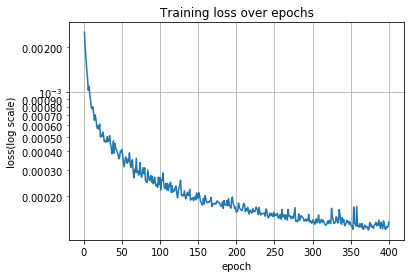

In [16]:
# plot loss over epoch
# Data for plotting
t = np.arange(1, 1+len(list_epoch_loss), 1)
fig, ax = plt.subplots()
plt.yscale('logit')
ax.plot(t, list_epoch_loss)

ax.set(xlabel='epoch', ylabel='loss(log scale)',
       title='Training loss over epochs')
ax.grid()

plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


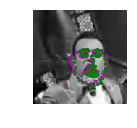

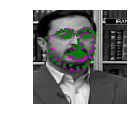

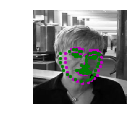

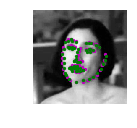

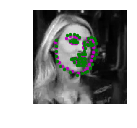

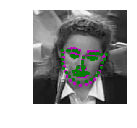

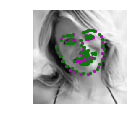

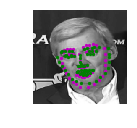

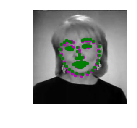

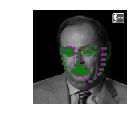

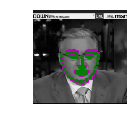

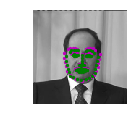

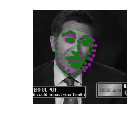

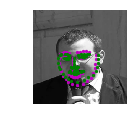

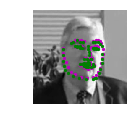

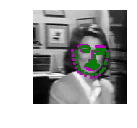

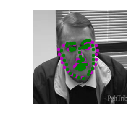

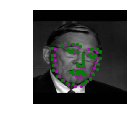

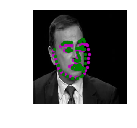

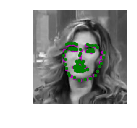

In [18]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu(), batch_size)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_20210401.pt' # 'keypoints_model_20190422.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:

Stochastic Gradient Descent(SGD) is chosen as the optimizer because:

- It is fast in training the network.
- It is simple to implement and robust in real application.

Mean Squared Error(MSE) is chosen as the loss function because:

- MSE is commonly used in regression applications as the loss function.
- The L2 norm accelerates the weight updating on parts of network that account for bigger losses.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:

I start with a architecture similar with the one proposed in [this paper](https://arxiv.org/pdf/1710.00977.pdf).

It is like:
    
    (Conv2D->RELU->Maxpooling->Dropout2D)*4 -> (FCL->RELU->Dropout)*2 -> FCL.
    
Where all the four Conv2D have a 3x3 kernel with stride 1 and padding 1, the dropout ratio increases from 0.1 to 0.6 as the layer gets deeper.

It works but the drawback is that a large number of epochs is needed in order to produce a decent result.

In order to reduce the training time. Three Batch Normalization(BN) layers are inserted into the first three convolutional layers with their dropout layers removed. The final architecture is like:

    (Conv2D->BN2D->RELU->Maxpooling)*3 -> (Conv2D->RELU->Maxpooling->Dropout2D) -> (FCL->RELU->Dropout)*2 -> FCL.
    
This new archtecture saves the training time by half and produce the same decent result.

There is no need to add more convolutional layers or any layers to avoid overfitting the data since dropout layers are aggressively used in this case.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:

Basically I start with a small number of epochs and gradually increase it until the model stops to improve.

A larger batch_size will help to speed up the training of model but on the other hand consume more memory. I have a 1080 ti installed on my local machine so I choose a large batch_size in this case.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.29208809  0.08784672 -0.08104156]
 [ 0.24530213 -0.17415899 -0.00472649]
 [ 0.21056135 -0.2601105   0.25342146]]
(3, 3)


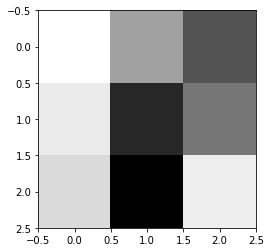

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 3

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

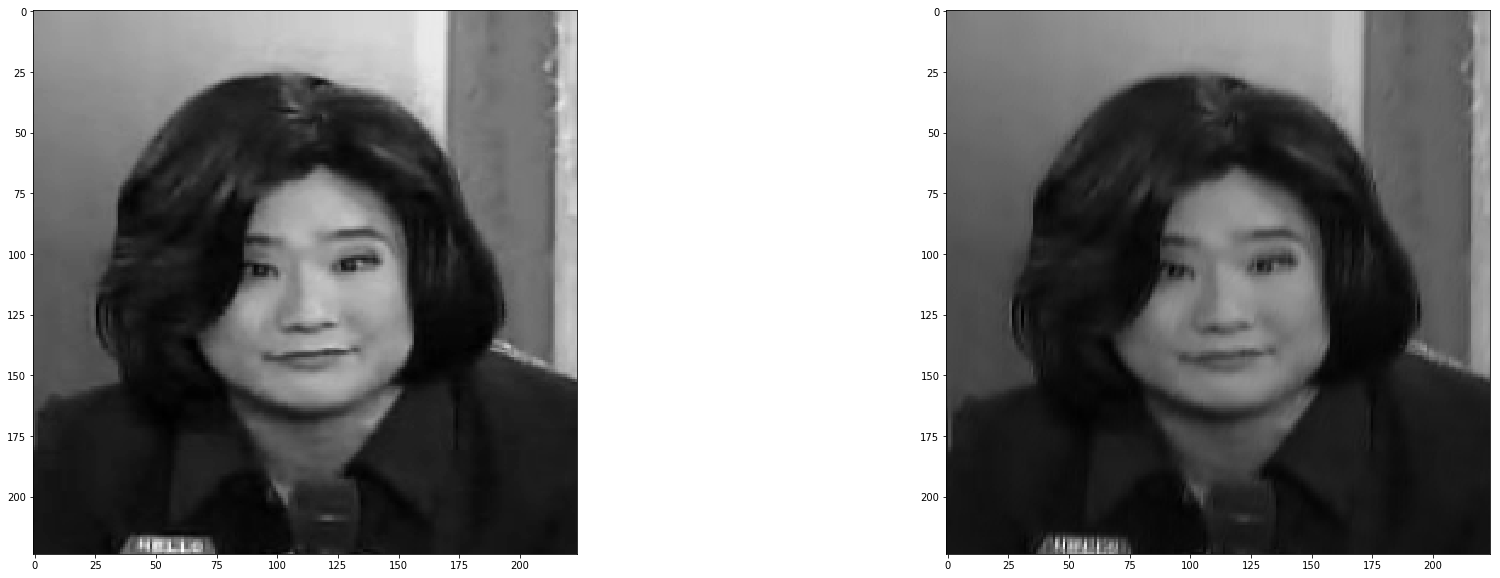

In [21]:
##TODO: load in and display any image from the transformed test dataset
# obtain one batch of testing images
dataiter = iter(test_loader)
images = dataiter.next()['image'].numpy()

# select image by index
idx = 0
img = np.squeeze(images[idx])

# display the original image on the left side
import cv2

fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
c = cv2.filter2D(img, -1, np.squeeze(w[filter_index])) # filtered image
fig.add_subplot(1, 2, 2)
plt.imshow(c, cmap='gray')

plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:

I test the filter with index 3 in the first convolutional layer. It calculates the value difference of pixels in the upper right against those in the lower left in a kernel. This detects features of gradients pointing from lower left to upper right. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!